<b>Entire assignment was done on Google Colaboratory</b>

In [1]:
#Connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/IIIT-B_CollabNB/CNN_assignment.zip'


In [ ]:
#Unzipping data
import os
os.chdir('/content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment')  #change dir
!unzip -q CNN_assignment.zip -d data/  #unzip data 

In [3]:
#Importing required libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [4]:
#Defining train and test datasets' paths
data_dir_train = pathlib.Path("/content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/train/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/train/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

### Data Exploration

In [5]:
#Checking count of images in train and test
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


- There are a total of 2357 images with 9 classes. 
- The train dataset has 2239 images and the test dataset has 118 images.

### Creating the dataset

In [6]:
#Defining batch size and required image size
batch_size = 32
img_height = 180
img_width = 180

In [7]:
#Train dataset 
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),  #Rescales images to required size
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
#Validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width), #Rescales images to required size
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
#Getting class names
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Data Visualisation
Visualizing one instance of all the nine classes present in the dataset

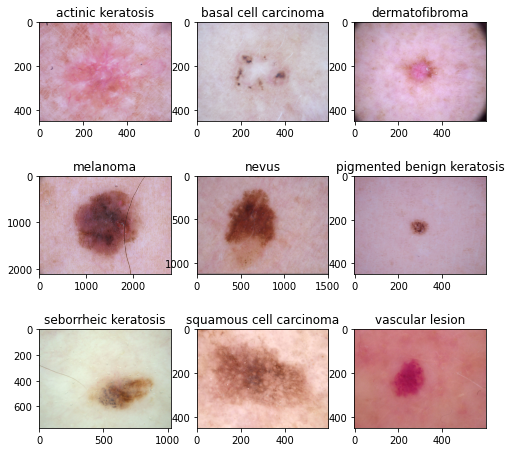

In [10]:
plt.figure(figsize=(8,8))
for i in range(0,len(class_names)):
  plt.subplot(3,3,i+1)
  im = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(im)

### Model Builidng

- Note: The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
#Defining CNN model
c=9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))  #Normalizes pixel values to [0,1] as RGB channel values are in the [0, 255] range, which is not ideal for a neural network. 
])
model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu', input_shape = (180, 180, 32)))  
model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3),
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(64, activation='relu')) # fully connected

#Softmax layer
model.add(Dense(c, activation = "softmax"))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                    

- First Layer: 32 kernels of size 3x3x3: 32x3x3x3(weights)+32(biases) = 896 trainable parameters. The output size will be [(180+2*0-3)/1]+1 = 178: 178x178x32 since each kernel produces a (178,178) feature map.
- Second Layer: 32 kernels of size 3x3x32 (32 channels): 32x32x3x3(weights)+32(biases) = 9248 trainable parameters. Each kernel has to convolve a tensor of size (178,178,32) from the previous layer. The output size will be [(178+2*0-3)/1]+1 = 176: 176x176x32.
- 1st Max Pool layer: The pooling layer gets the (176,176,32) input from the previous conv layer and produces a (88,88,32) output (the default pooling uses stride of 2). There are no trainable parameters in the pooling layer.
- Third Layer: 32 kernels of size 3x3: 32x32x3x3(weights)+32(biases) = 9248 trainable parameters. Each kernel has to convolve a tensor of size (88,88,32) from the previous layer. The output size will be [(88+2*0-3)/1]+1 = 86:86x86x32.
- 2nd Max Pool layer: Gets input of size (86,86,32) and produces a (43,43,32) output.
- Fourth Layer: 32 kernels of size 3x3: 32x32x3x3(weights)+32(biases) = 9248 trainable parameters. Each kernel has to convolve a tensor of size (43,43,32) from the previous layer. The output size will be [(43+2*0-3)/1]+1 = 41:41x41x32.
- 3rd Max Pool layer: Gets input of size (41,41,32) and produces a (20,20,32) output.
- Fifth Layer: 32 kernels of size 3x3: 32x32x3x3(weights)+32(biases) = 9248 trainable parameters. Each kernel has to convolve a tensor of size (20,20,32) from the previous layer. The output size will be [(20+2*0-3)/1]+1 = 18:18x18x32.
- 4th Max Pool layer: Gets input of size (18,18,32) and produces a (9,9,32) output.
- Flatten layer: Takes in the (9,9,32) output from the previous layer and 'flattens' it into a vector of length 9 x 9 x 32 = 2592.
- Dense layer: Fully connected layer with 64 neurons. It takes the 2592-dimensional output vector as the input and has 64x2592 (weights)+64(biases) = 1,65,952 trainable parameters. The output of this layer is a 64-dimensional vector.
- Dense softmax layer: Has 9 neurons which takes the 64-dimensional vector from the previous layer as input. It has 64 x 9 (weights) + 9 (biases) = 585 trainable parameters.
- **Total no. of trainable parameters: 2,04,425**.

In [13]:
#Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam',
              metrics=['accuracy'])

<b>Note</b>: Sparse categorical cross entropy loss function has been used taking into account the error ValueError: Shapes (None, 1) and (None, 50) are incompatible that gets thrown when categorical cross entropy is used. The error occurs as 'categorical_crossentropy' works on one-hot encoded target, while 'sparse_categorical_crossentropy' works on integer target.
Refer: https://www.kaggle.com/general/197993

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 86, 86, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                    

<i>No. of trainable params are 2,04,425 as calculated. </i>

In [15]:
#Training the model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 365s 1s/step - loss: 2.0943 - accuracy: 0.1920 - val_loss: 2.0316 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 6s 106ms/step - loss: 1.9886 - accuracy: 0.2243 - val_loss: 1.8355 - val_accuracy: 0.3378
Epoch 3/20
56/56 [==============================] - 6s 104ms/step - loss: 1.7773 - accuracy: 0.3387 - val_loss: 1.6464 - val_accuracy: 0.4027
Epoch 4/20
56/56 [==============================] - 6s 104ms/step - loss: 1.6540 - accuracy: 0.4035 - val_loss: 1.6206 - val_accuracy: 0.4295
Epoch 5/20
56/56 [==============================] - 6s 104ms/step - loss: 1.6063 - accuracy: 0.4213 - val_loss: 1.5562 - val_accuracy: 0.4497
Epoch 6/20
56/56 [==============================] - 6s 104ms/step - loss: 1.5552 - accuracy: 0.4314 - val_loss: 1.5242 - val_accuracy: 0.4631
Epoch 7/20
56/56 [==============================] - 6s 105ms/step - loss: 1.4498 - accuracy: 0.4967 - val_loss: 1.5063 - val_accuracy: 0.4855
Epoch 8

- Accuracy:
>Training: 68.36% <br> 
>Validation: 47.65%
-Loss:
>Training: 0.92 <br> 
>Validation: 1.77



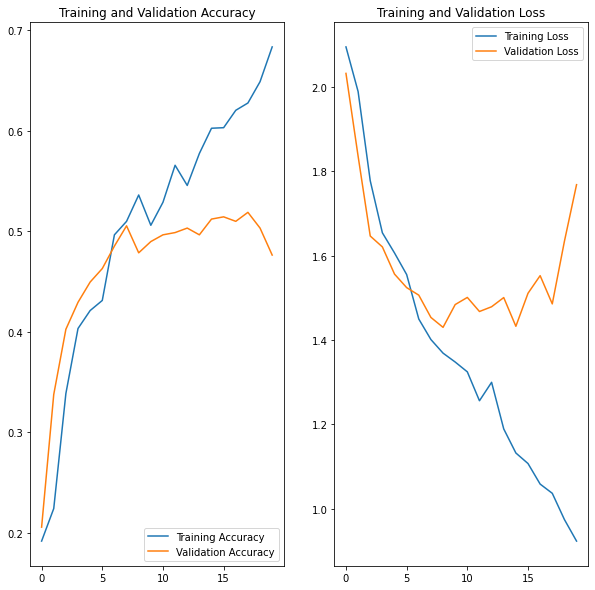

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Accuracy: Training and validation accuracy increase together and there is little difference between the two till the 9th epoch where it starts to diverge. Around the 11th epoch, the validation accuracy starts to drop and is consistently lower than the training accuracy. There is a quite difference between validation and training accuracy indicating **overfitting**. Training accuracy at epoch 20 is around 68% while validation accuracy is only around 48%.

- Loss: Both, training and validation loss, decrease together and there is little difference between the two till the 9th epoch where it starts to diverge, similar trend as accuracy graph. Beyond that training loss is far lower than validation loss and the difference in loss only increases further, till epoch 20, once again indicating **overfitting**.

### Data Augmentation

As there is overfitting, data augmentation strategy needs to be implemented. Following data augmentation strategies have been implemented:
1. Rotation - Rotation by a factor of 0.3 (rotation by a random amount in the range [-30% * 2pi, 30% * 2pi]) and fill_mode = 'wrap', input is extended by wrapping around to the opposite edge.
2. Flipping - Flips image horizontally and vertically
3. Zooming out - Output is zoomed out by a random amount in the range [+20%, +30%].
4. Change contrast - randomly adjust the contrast of image by a random factor: For each channel, this layer computes the mean of the image pixels in the channel and then adjusts each component x of each pixel to (x - mean) * contrast_factor + mean.

<i>Refer: www.tensorflow.org</i> 

In [17]:
aug = keras.Sequential([layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3), seed=123),
                        layers.experimental.preprocessing.RandomRotation(0.3, fill_mode='wrap', seed=123),
                        layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='wrap', seed=123),
                        layers.experimental.preprocessing.RandomContrast(factor=0.2, seed=123)])

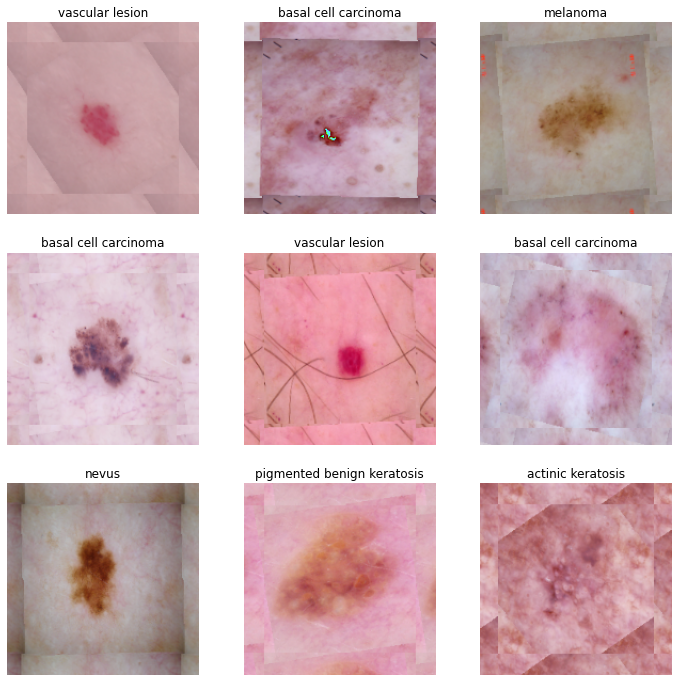

In [18]:
#Visualising an instance of augmented data
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(aug(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [19]:
#Defining model on augmented data and adding dropout layers to reduce overfitting
model = Sequential([aug, layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu', input_shape = (img_height, img_width, 32)))  
model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3),
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(64, activation='relu')) # fully connected
model.add(Dropout(0.25))


#Softmax layer
model.add(Dense(c, activation = "softmax"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 conv2d_6 (Conv2D)           (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 88, 88, 32)        0         
                                                      

<i>No. of trainable params do not change, there are no trainable params in drouput layers, (model is same otherwise)</i>

In [20]:
#Compiling the new model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam',
              metrics=['accuracy'])

In [21]:
#Training the new model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 8s 121ms/step - loss: 2.0696 - accuracy: 0.1903 - val_loss: 2.0905 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 6s 116ms/step - loss: 2.0368 - accuracy: 0.1992 - val_loss: 2.0253 - val_accuracy: 0.3468
Epoch 3/20
56/56 [==============================] - 7s 117ms/step - loss: 1.8971 - accuracy: 0.2919 - val_loss: 1.7208 - val_accuracy: 0.3893
Epoch 4/20
56/56 [==============================] - 7s 116ms/step - loss: 1.7077 - accuracy: 0.3728 - val_loss: 1.6936 - val_accuracy: 0.4004
Epoch 5/20
56/56 [==============================] - 7s 117ms/step - loss: 1.7104 - accuracy: 0.3599 - val_loss: 1.6444 - val_accuracy: 0.4094
Epoch 6/20
56/56 [==============================] - 7s 116ms/step - loss: 1.7183 - accuracy: 0.3806 - val_loss: 1.6209 - val_accuracy: 0.4519
Epoch 7/20
56/56 [==============================] - 7s 117ms/step - loss: 1.5896 - accuracy: 0.4258 - val_loss: 1.5826 - val_accuracy: 0.4564
Epoch 

- Accuracy:
>Training: 53.01% (Prev model: 68.36%) <br> 
>Validation: 50.34% (Prev model: 47.65%)

The training accuracy has gone down compared to the previous model while validation accuracy has gone up slightly. The difference between training and validation accuracy has gone down drastically as compared to the previous model, indicating the model is no longer overfitting.

- Loss:
>Training: 1.32 (Prev model: 0.92) <br> 
>Validation: 1.41 (Prev model: 1.77) <br>

The training loss has gone up compared to the previous model while validation loss has gone down slightly. The difference between training and validation loss has gone down drastically as compared to the previous model, indicating the model is no longer overfitting.



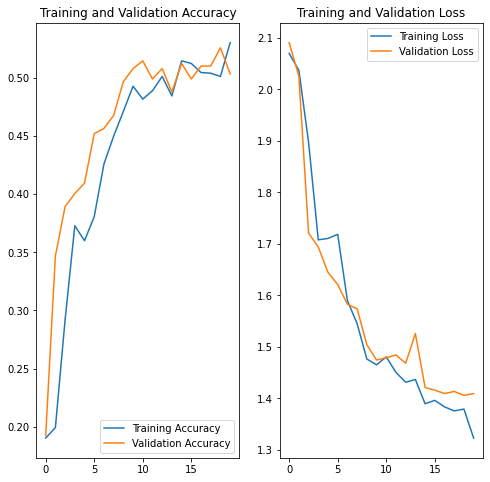

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Accuracy: Both training and validation accuracies both increase together and no longer diverge after a point, indicating that the model is no longer overfitting.
- Loss: The training and validation loss also follow the same pattern and decrease together, indicating that the model is no longer overfitting.

<i>Although there is a slight decrease in accuracy and increase in loss, this model is an improvement from the previous one as it does not overfit.</i>

### Class Distribution

In [23]:
import glob as gl

In [24]:
train_im_names = gl.glob('/content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/*/*.jpg')
train_im_names = pd.Series(train_im_names)
class_df = pd.DataFrame()

class_df['Imgname'] = train_im_names.map(lambda x: x.split("/")[-1])

class_df['Class'] = train_im_names.map(lambda x: x.split("/")[-2])

class_df.head()

,Imgname,Class
0,ISIC_0026575.jpg,actinic keratosis
1,ISIC_0028063.jpg,actinic keratosis
2,ISIC_0029500.jpg,actinic keratosis
3,ISIC_0025825.jpg,actinic keratosis
4,ISIC_0026905.jpg,actinic keratosis


#### Checking for class imbalance

In [25]:
pd.value_counts(class_df['Class'])

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Class, dtype: int64

In [26]:
import seaborn as sns

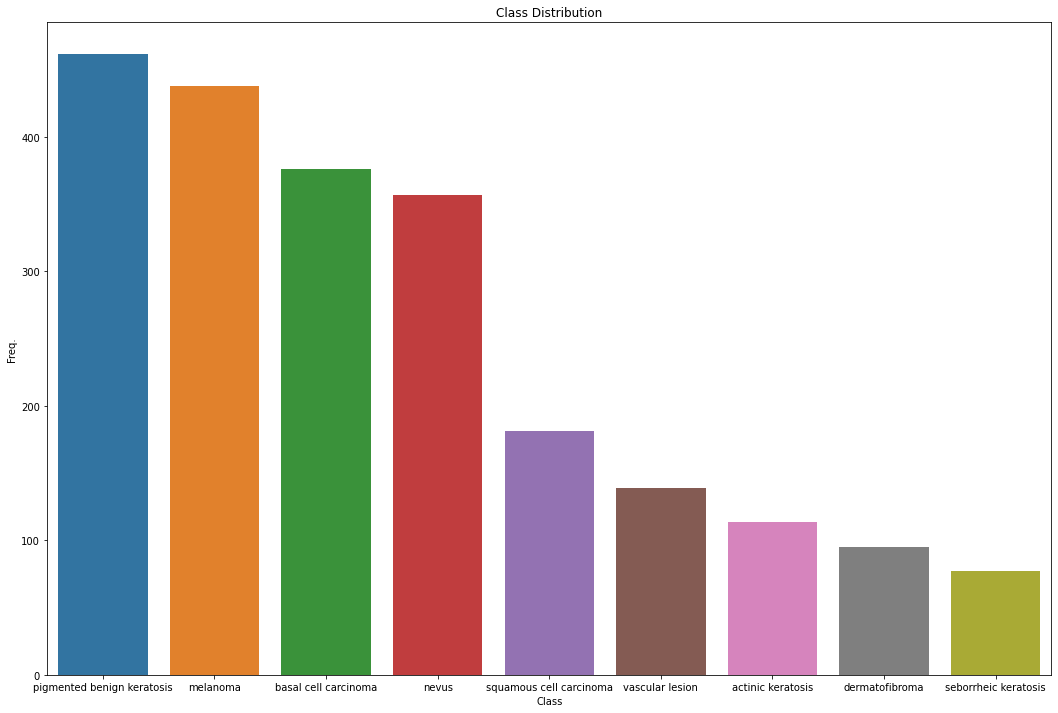

In [27]:
plt.figure(figsize=[18,12])
sns.barplot(x=pd.value_counts(class_df['Class']).index,y=pd.value_counts(class_df['Class']))
plt.xlabel('Class')
plt.ylabel('Freq.')
plt.title('Class Distribution')
plt.show()

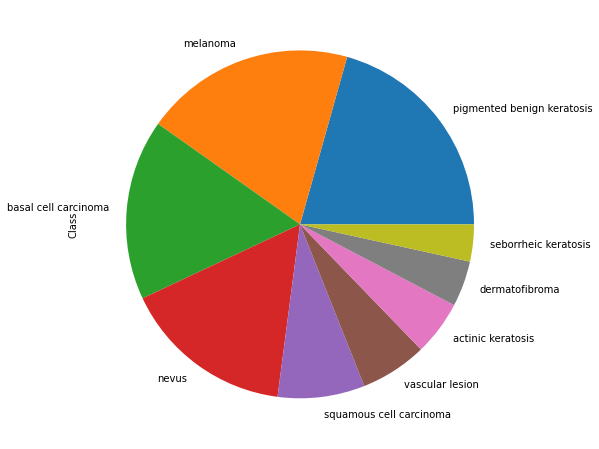

In [28]:
plt.figure(figsize=[8,8])
pd.value_counts(class_df['Class']).plot(kind='pie')
plt.show()

Both, the barplot and the pie chart above clearly shows the class imbalance present in the dataset. The type 'seborrheic keratosis' has only 77 instances while pigmented benign keratosis has 462.
- **Least** number of samples: **seborrheic keratosis - 77**
- Classes that **dominate** the data in terms of proportionate number of samples:  **pigmented benign keratosis (462), melanoma (438), basal cell carcinoma (376) and nevus (357).**

### Rectifying class imbalance
The augmentor package will be used to add more samples across all classes so that none of the classes have very few samples.
1. Instantiate a `Pipeline` object pointing to a directory containing initial image data set.<br>
2. Define a number of operations to perform on this data set using `Pipeline` object.
3. Execute these operations by calling the `Pipeline’s` `sample()` method.

In [30]:
!pip install Augmentor

In [31]:
import Augmentor

In [33]:
#Defining new path for augmented data to be stored along with original dataset. Train is a copy of the original dataset which will now contain the new images too
data_dir_train_aug = pathlib.Path('/content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
path_to_training_dataset=str(data_dir_train_aug)+'/'
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6D2489EDD0>: 100%|██████████| 500/500 [00:22<00:00, 22.55 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6D24882A90>: 100%|██████████| 500/500 [00:25<00:00, 19.88 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6D24836B10>: 100%|██████████| 500/500 [00:26<00:00, 18.56 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6CAFE102D0>: 100%|██████████| 500/500 [01:53<00:00,  4.41 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6D24831590>: 100%|██████████| 500/500 [01:28<00:00,  5.64 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6DA18D8510>: 100%|██████████| 500/500 [00:22<00:00, 22.01 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6D255CEA50>: 100%|██████████| 500/500 [00:52<00:00,  9.45 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6D2502E410>: 100%|██████████| 500/500 [00:23<00:00, 21.44 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6D255DEE10>: 100%|██████████| 500/500 [00:23<00:00, 21.35 Samples/s]


- Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.

In [35]:
#Total count of augmented images
image_count_train = len(list(data_dir_train_aug.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Distribution of augmented data after adding new images to the original training data**

In [39]:
path_list = [x for x in gl.glob(os.path.join(data_dir_train_aug, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031609.jpg_be26840e-915b-4885-b1d5-c2b2c0405eb2.jpg',
 '/content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026575.jpg_5a622681-5236-4da7-aee5-13459fde9aa7.jpg',
 '/content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028063.jpg_1899725f-37ea-4810-82d6-9bed663534e2.jpg',
 '/content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031335.jpg_30cbbc05-ee09-45e4-90e1-55d616acccbb.jpg',
 '/content/drive/MyDrive/IIIT-B_Coll

In [40]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in gl.glob(os.path.join(data_dir_train_aug, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [41]:
#Creating new dataframe with new images as well
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Imgname','Class'])
new_df = class_df.append(df2)
new_df.head()

,Imgname,Class
0,ISIC_0026575.jpg,actinic keratosis
1,ISIC_0028063.jpg,actinic keratosis
2,ISIC_0029500.jpg,actinic keratosis
3,ISIC_0025825.jpg,actinic keratosis
4,ISIC_0026905.jpg,actinic keratosis


In [43]:
#Checking updated count
pd.value_counts(new_df['Class'])

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Class, dtype: int64

In [44]:
batch_size = 32
img_height = 180
img_width = 180

In [45]:
#Creating training dataset based on imbalance recitifed data
data_dir_train="/content/drive/MyDrive/IIIT-B_CollabNB/CNN Assignment/data/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [46]:
#Creating validation dataset based on imbalance recitifed data
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [47]:
#Building model on imbalance recitifed data
model = Sequential([ layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))])

model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu', input_shape = (img_height, img_width, 32)))  
model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3),
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 32, kernel_size = (3,3), 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(64, activation='relu')) # fully connected
model.add(Dropout(0.25))


#Softmax layer
model.add(Dense(c, activation = "softmax"))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 176, 176, 32)      9248      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 88, 88, 32)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 86, 86, 32)        9248      
                                                      

In [48]:
#Compiling the model
model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam',
              metrics=['accuracy'])

In [49]:
#Training the model for 50 epochs this time
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 45s 254ms/step - loss: 2.1753 - accuracy: 0.1376 - val_loss: 2.1864 - val_accuracy: 0.1396
Epoch 2/50
169/169 [==============================] - 43s 246ms/step - loss: 2.1091 - accuracy: 0.1860 - val_loss: 2.0623 - val_accuracy: 0.2086
Epoch 3/50
169/169 [==============================] - 43s 248ms/step - loss: 1.8533 - accuracy: 0.2832 - val_loss: 1.7109 - val_accuracy: 0.3756
Epoch 4/50
169/169 [==============================] - 45s 257ms/step - loss: 1.6829 - accuracy: 0.3644 - val_loss: 1.5910 - val_accuracy: 0.3972
Epoch 5/50
169/169 [==============================] - 45s 258ms/step - loss: 1.5592 - accuracy: 0.3960 - val_loss: 1.4822 - val_accuracy: 0.4076
Epoch 6/50
169/169 [==============================] - 48s 276ms/step - loss: 1.4961 - accuracy: 0.4145 - val_loss: 1.4449 - val_accuracy: 0.4284
Epoch 7/50
169/169 [==============================] - 45s 257ms/step - loss: 1.4240 - accuracy: 0.4444 - val_loss: 1.4069 - val_ac

- Accuracy:
>Training: 85.85% (2nd model: 53.01%, 1st model: 68.36%) <br> 
>Validation: 80.25% (2nd model: 50.34%, 1st model: 47.65%)

After rectifying class imbalance, both, training and validation accuracies have increased by a lot as compared to the previous models. The difference between training and validation accuracy is quite small, indicating the model is not overfitting.

- Loss:
>Training: 0.36 (2nd model: 1.32 ,1st model: 0.92) <br> 
>Validation: 0.65 (2nd model: 1.41, 1st model: 1.77) <br>

Both, training and validation losses have decreased by a lot as compared to the previous models. The difference between training and validation loss is quite small, indicating the model is not overfitting.


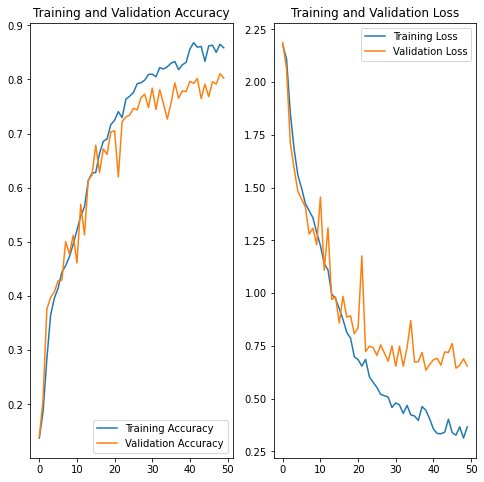

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- Accuracy: Both training and validation accuracies both increase together and do not diverge after a point, indicating that the model is not overfitting.
- Loss: The training and validation loss also follow the same pattern and decrease together, indicating that the model is not overfitting.

The model has a training accuracy of ~86%, validation accuracy ~80% (good overall), training loss of 0.36, validation loss of 0.65,does not overfit and does not have class imbalance. Therefore, it perfoms far better than the other two models. 